<a href="https://www.kaggle.com/code/lawalsontomiwa/chelsea-tweets-sentiment-analysis?scriptVersionId=125429747" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### INTRODUCTION

The Project focuses on extracting the reactions and sentiments of fans on twitter, following the sack of Chelsea manager Graham potter and their view on the potential candidates to replace him as manager of the club

Reports say Graham potter was sacked at exactly 2.45 pm on Sunday but the news did not become common knowledge until the 3rd of April (Monday), so tweets from the 3rd have been scraped till the appointment of a new manager

We will follow the trends, analyze the sentiments and see if the appointment will go in favour of the fans choice

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
plt.style.use('ggplot')
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
df= pd.read_csv('/kaggle/input/chelsea-tweets/finals.csv')

In [3]:
df.head()

,Unnamed: 0,date,id,content,username,like_count,retweet_count
0,0,2023-04-06 03:02:44+00:00,1643811448873947138,If the idea of Super Frank as manager for two ...,MrGeorgeBenson,0,0
1,1,2023-04-06 03:02:22+00:00,1643811356674764800,Blithe Doyle Candice Geordie #合肥旅游 #合肥 https:/...,babyphat525,0,0
2,2,2023-04-06 03:02:20+00:00,1643811348470460418,@misskittyf Understandable,panelsandprose,0,0
3,3,2023-04-06 03:02:12+00:00,1643811312386945026,@CFCPys @Matt_Law_DT Yes I’m back on Twitter r...,OluwoleOwos,0,0
4,4,2023-04-06 03:02:01+00:00,1643811268695048192,…2/2. from the ‘feels’ department and to be h...,loztor,0,0


In [4]:
df.shape

(7545, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7545 entries, 0 to 7544
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     7545 non-null   int64 
 1   date           7545 non-null   object
 2   id             7545 non-null   int64 
 3   content        7545 non-null   object
 4   username       7545 non-null   object
 5   like_count     7545 non-null   int64 
 6   retweet_count  7545 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 412.7+ KB


In [6]:
df.describe()

,Unnamed: 0,id,like_count,retweet_count
count,7545.000000,7.545000e+03,7545.000000,7545.000000
mean,1942.554274,1.643741e+18,8.210338,0.653148
std,1454.428632,1.685314e+14,153.807122,10.551666
min,0.000000,1.642681e+18,0.000000,0.000000
25%,672.000000,1.643755e+18,0.000000,0.000000
50%,1615.000000,1.643780e+18,0.000000,0.000000
75%,3115.000000,1.643798e+18,1.000000,0.000000
max,5001.000000,1.643819e+18,7936.000000,466.000000


In [7]:
df.drop(['Unnamed: 0'], axis=1,inplace=True)

In [8]:
#Lets look at all the major candidates and names that trended during these period 
Nagelsmann = ['JulianNagelsmann', 'Julian Nagelsmann', 'Julian', 'Nagelsmann', 'Nagelsmann\'s']
Enrique= ['LuisEnrique', 'Luis Enrique', 'Luis', 'Enrique','Enrique\'s']
Conte = ['AntonioConte','Antonio Conte','Antonio','Conte', 'Conte\'s' ]
Potter=['GrahamPotter', 'Graham Potter','Graham', 'Potter','Potter\'s']
Lampard=['FrankLampard','Frank Lampard','Frank','Lampard','Lampard\'s']

We could include Thomas Tuchel but after what chelsea fans have experienced post his sack , I think its safe to say most of us regard him as the football messiah  

In [9]:
def identify_subject(tweets, refs):
    flag = 0 
    for ref in refs:
        if tweets.find(ref) != -1:
            flag = 1
    return flag

df['Nagelsmann'] = df['content'].apply(lambda x: identify_subject(x, Nagelsmann)) 
df['Enrique'] = df['content'].apply(lambda x: identify_subject(x, Enrique))
df['Conte'] = df['content'].apply(lambda x: identify_subject(x, Conte))
df['Potter'] = df['content'].apply(lambda x: identify_subject(x, Potter))
df['Lampard'] = df['content'].apply(lambda x: identify_subject(x, Lampard))
df.head(10)

,date,id,content,username,like_count,retweet_count,Nagelsmann,Enrique,Conte,Potter,Lampard
0,2023-04-06 03:02:44+00:00,1643811448873947138,If the idea of Super Frank as manager for two ...,MrGeorgeBenson,0,0,0,0,0,0,1
1,2023-04-06 03:02:22+00:00,1643811356674764800,Blithe Doyle Candice Geordie #合肥旅游 #合肥 https:/...,babyphat525,0,0,0,0,0,0,0
2,2023-04-06 03:02:20+00:00,1643811348470460418,@misskittyf Understandable,panelsandprose,0,0,0,0,0,0,0
3,2023-04-06 03:02:12+00:00,1643811312386945026,@CFCPys @Matt_Law_DT Yes I’m back on Twitter r...,OluwoleOwos,0,0,0,0,0,0,0
4,2023-04-06 03:02:01+00:00,1643811268695048192,…2/2. from the ‘feels’ department and to be h...,loztor,0,0,0,0,0,0,0
5,2023-04-06 03:02:00+00:00,1643811264580456450,2/2…. As a lifelong Chelsea fan this season ha...,loztor,0,0,0,0,0,0,0
6,2023-04-06 03:01:58+00:00,1643811256686755841,✨✨ Good morning 🌸🌸🌸🌸🌸🌸 \n#太原资源 #太原丝足 https://t...,chelsea_shandi,0,0,0,0,0,0,0
7,2023-04-06 03:01:51+00:00,1643811226755932161,@danasflxapl Yes Chelsea!!!!,CaptainLewinsky,0,0,0,0,0,0,0
8,2023-04-06 03:01:50+00:00,1643811219843760138,"@CarefreeRex @SJftbI Did we spend 600m, if fai...",ChristianOnah5,0,0,0,0,0,0,0
9,2023-04-06 03:01:38+00:00,1643811172968177666,@DaveOnFXX But is it Booby because of this fee...,chelseaisameyer,0,0,0,0,0,0,0


### DATA CLEANING

In [10]:
df[df['username'].str.contains('MrGeorgeBenson')]

,date,id,content,username,like_count,retweet_count,Nagelsmann,Enrique,Conte,Potter,Lampard
0,2023-04-06 03:02:44+00:00,1643811448873947138,If the idea of Super Frank as manager for two ...,MrGeorgeBenson,0,0,0,0,0,0,1
942,2023-04-06 01:54:57+00:00,1643794390354374656,CHELSEA APPOINT FRANK LAMPARD AS NEW CHELSEA M...,MrGeorgeBenson,44,2,0,0,0,0,0
5845,2023-04-06 03:10:37+00:00,1643813434084175874,If Frank Lampard wins Chelsea the Champions Le...,MrGeorgeBenson,111,7,0,0,0,0,1
5965,2023-04-06 03:02:44+00:00,1643811448873947138,If the idea of Super Frank as manager for two ...,MrGeorgeBenson,168,14,0,0,0,0,1
6902,2023-04-06 01:54:57+00:00,1643794390354374656,CHELSEA APPOINT FRANK LAMPARD AS NEW CHELSEA M...,MrGeorgeBenson,53,2,0,0,0,0,0


so we have duplicate values , but some of them carry a value in the like_count column

In [11]:
df.loc[df.duplicated(subset=['id', 'username', 'content']),:][:10]

,date,id,content,username,like_count,retweet_count,Nagelsmann,Enrique,Conte,Potter,Lampard
5002,2023-04-06 02:12:43+00:00,1643798862962761728,Luis Enrique next coach chelsea https://t.co/4...,Marti69824329,0,0,0,1,0,0,0
5003,2023-04-06 02:08:30+00:00,1643797800730218503,@AdamCrafton_ @COsoccerpod I think this is mak...,cfcinBrooklyn,0,0,0,0,0,0,0
5004,2023-04-06 01:22:43+00:00,1643786280294309890,@FutbolCheIsea Chelsea fans will always compla...,English23433679,0,0,0,0,0,0,0
5005,2023-04-06 00:27:01+00:00,1643772261864800256,CHELSEA!! \n\nMaybe their ambitions are a tast...,robertmarawa,9,2,0,0,0,0,0
5006,2023-04-06 00:18:35+00:00,1643770140285083648,This is the best news possible for a caretaker...,MisterTowle2,0,0,0,0,0,0,1
5007,2023-04-05 23:42:12+00:00,1643760983851036672,"@Mohxmmad Yes that's right, Luis Enrique is th...",AbdallaWasiir,0,0,0,1,0,0,0
5008,2023-04-05 23:36:35+00:00,1643759569812832258,@akomeahmessiah They just want the Chelsea fan...,Marluking1,0,0,0,0,0,0,0
5009,2023-04-05 23:15:14+00:00,1643754195269582848,@flameosumeet Miss seeing Steve Clark.\n\nVery...,elebros,0,0,0,0,0,0,1
5010,2023-04-05 22:51:58+00:00,1643748342583955456,#FrankLampard holding down things while we get...,EvelynBA64,0,0,0,0,0,0,1
5011,2023-04-05 22:47:33+00:00,1643747227519844352,"@TheBig6ixShow And moreover, Chelsea board sho...",TheShedEndMedia,0,0,0,0,0,1,0


In [12]:
#we will be removing the first duplicate forms as the last variations carry a value in the like_counts columns
df1=df.drop_duplicates(subset=['id', 'username', 'content'],keep='last')

In [13]:
df1.shape

(5954, 11)

In [14]:
df1.reset_index(drop=True, inplace=True)

In [15]:
#lets view the number of the candidates
print('Nagelsman =',len(df1[df1['Nagelsmann']==1]))
print('Potter = ',len(df1[df1['Potter']==1]))
print('Lampard = ',len(df1[df1['Lampard']==1]))
print('Enrique = ',len(df1[df1['Enrique']==1]))
print('Conte = ',len(df1[df1['Conte']==1]))

Nagelsman = 167
Potter =  189
Lampard =  767
Enrique =  209
Conte =  137


As we can see from the results , there was alot of tweets following the news of Lampard taking charge as interim coach. Note the scraping stopped the moment the news was official 

In [16]:
df1['content'][38]

'@IsaBusariEsq May the Good Lord be with your beloved Chelsea. 😅'

Interesting tweet, tough time to be a chelsea fan.....
we need to remove hashtags, links .etc and clean the tweets , so as aid the model

In [17]:
# using regex to remove hashtags, RT, url, tags, emojis
def cleantext(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+','', txt)
    txt = re.sub(r'#','',txt) 
    txt = re.sub(r'RT :','',txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    txt= re.sub(r'[^\w\s]','', txt)
    return txt

In [18]:
df1['clean_tweet']=df1['content'].apply(cleantext)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### SENTIMENT ANALYSIS

We will be using bert pre-training language representations from hugging face 

In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
def polarity_scores(tweets):
    encoded_text = tokenizer(tweets, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'Negative' : scores[0],
        'Neutral' : scores[1],
        'Positive' : scores[2]
    }
    return scores_dict

In [21]:
res = {}
for i, row in tqdm(df1.iterrows(), total=len(df1)):
    try:
        tweet = row['clean_tweet']
        myid = row['id']
        res[myid] = polarity_scores(tweet)
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/5954 [00:00<?, ?it/s]

In [22]:
df2= pd.DataFrame(res).T
df2 = df2 .reset_index().rename(columns={'index': 'id'})
df2  = df2 .merge(df1, how='left')

In [23]:
df2.head()

,id,Negative,Neutral,Positive,date,content,username,like_count,retweet_count,Nagelsmann,Enrique,Conte,Potter,Lampard,clean_tweet
0,1643810745543536640,0.950165,0.045467,0.004368,2023-04-06 02:59:56+00:00,That noose with the American flag in the backg...,UmEarth2Chelsea,2,0,0,0,0,0,0,That noose with the American flag in the backg...
1,1643809408340705280,0.003375,0.019196,0.977429,2023-04-06 02:54:38+00:00,I love being a woman. #tinder https://t.co/ZGi...,CasuallyChelsea,0,0,0,0,0,0,0,I love being a woman tinder
2,1643806349216698368,0.003747,0.133045,0.863208,2023-04-06 02:42:28+00:00,More honors for our bulldogs! https://t.co/CSg...,ChelseaBoysHoop,0,0,0,0,0,0,0,More honors for our bulldogs
3,1643804164957380612,0.061928,0.813687,0.124385,2023-04-06 02:33:47+00:00,@CFCPys @SkySportsNews If osimhen were to sign...,Authordwonder,0,0,0,0,0,0,0,If osimhen were to sign for chelsea would he...
4,1643802653481156608,0.069247,0.436343,0.494411,2023-04-06 02:27:47+00:00,As Chelsea fan y’all need to relax and enjoy t...,muminmoalim18,0,0,0,0,0,0,0,As Chelsea fan yall need to relax and enjoy th...


In [24]:
display(df2[df2['Nagelsmann']==1][['Nagelsmann','Negative','Neutral','Positive']].groupby('Nagelsmann').sum(),
df2[df2['Enrique']==1][['Enrique','Negative','Neutral','Positive']].groupby('Enrique').sum(),
df2[df2['Potter']==1][['Potter','Negative','Neutral','Positive']].groupby('Potter').sum(),
df2[df2['Conte']==1][['Conte','Negative','Neutral','Positive']].groupby('Conte').sum(),
df2[df2['Lampard']==1][['Lampard','Negative','Neutral','Positive']].groupby('Lampard').sum())   

,Negative,Neutral,Positive
Nagelsmann,,,
1,28.009319,103.116486,35.874195


,Negative,Neutral,Positive
Enrique,,,
1,29.260107,134.980087,44.759808


,Negative,Neutral,Positive
Potter,,,
1,66.439949,91.579933,30.980114


,Negative,Neutral,Positive
Conte,,,
1,24.78961,86.337029,25.873365


,Negative,Neutral,Positive
Lampard,,,
1,193.62291,392.505371,180.871704


### Summary

Taking into consideration that lampard had far more tweets than any of the other mentioned names , His results still show a high number of negatives and alot of neutrals

Potter cant catch a break , His tweets are plagued with negative sentiments 

Enrique and Nagelsmann tweets show a far better difference between their negative tweets and positive tweets as they are the only ones that their positie sentiments are higher than negative

Conte on the other hand seems to have a fairly balanced neutral sentiments 

In [25]:
#lets create a maximum value column 
max_column = []
for i,j,v in zip(df2.Negative,df2.Neutral,df2.Positive):
    if i is max(i,j,v):
        max_column.append("Negative")
    elif j is max(i,j,v):
        max_column.append("Neutral")
    else:
        max_column.append("Positive")
        
        
df2.insert(4, "sentiment", max_column)

In [26]:
df2.head()

,id,Negative,Neutral,Positive,sentiment,date,content,username,like_count,retweet_count,Nagelsmann,Enrique,Conte,Potter,Lampard,clean_tweet
0,1643810745543536640,0.950165,0.045467,0.004368,Negative,2023-04-06 02:59:56+00:00,That noose with the American flag in the backg...,UmEarth2Chelsea,2,0,0,0,0,0,0,That noose with the American flag in the backg...
1,1643809408340705280,0.003375,0.019196,0.977429,Positive,2023-04-06 02:54:38+00:00,I love being a woman. #tinder https://t.co/ZGi...,CasuallyChelsea,0,0,0,0,0,0,0,I love being a woman tinder
2,1643806349216698368,0.003747,0.133045,0.863208,Positive,2023-04-06 02:42:28+00:00,More honors for our bulldogs! https://t.co/CSg...,ChelseaBoysHoop,0,0,0,0,0,0,0,More honors for our bulldogs
3,1643804164957380612,0.061928,0.813687,0.124385,Neutral,2023-04-06 02:33:47+00:00,@CFCPys @SkySportsNews If osimhen were to sign...,Authordwonder,0,0,0,0,0,0,0,If osimhen were to sign for chelsea would he...
4,1643802653481156608,0.069247,0.436343,0.494411,Positive,2023-04-06 02:27:47+00:00,As Chelsea fan y’all need to relax and enjoy t...,muminmoalim18,0,0,0,0,0,0,0,As Chelsea fan yall need to relax and enjoy th...


### DATA ANALYSIS AND VISUALIZATION

Lets look at the sentiments of the entire dataset

<BarContainer object of 3 artists>

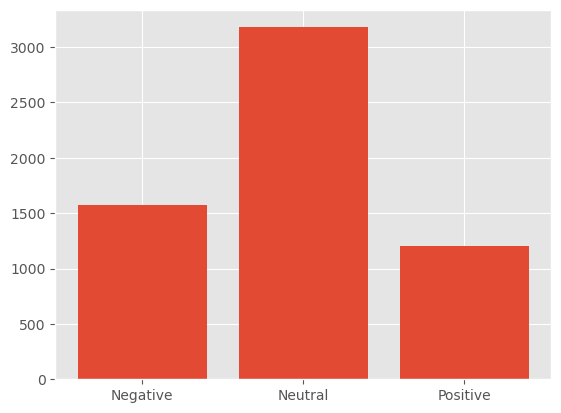

In [27]:
labels=df2.groupby('sentiment').count().index.values
values=df2.groupby('sentiment').size().values
plt.bar(labels,values)

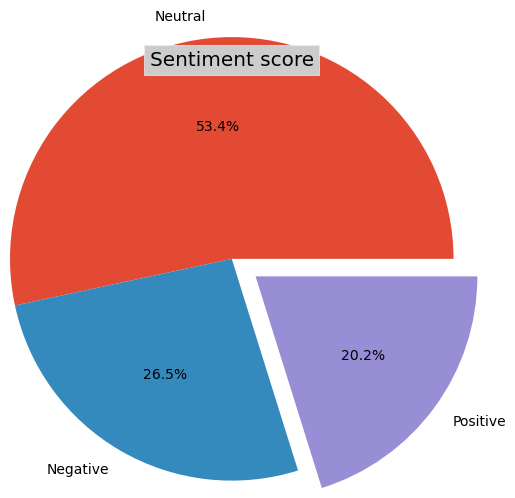

In [28]:
sen=df2['sentiment'].value_counts()
plt.pie(sen.values, labels=sen.index, autopct='%0.1f%%',radius=1.5, startangle=360, explode=[0,0,0.2])
plt.title('Sentiment score', weight='bold')
plt.title("Sentiment score", bbox={'facecolor':'0.8', 'pad':4})
plt.rcParams['figure.figsize'] = [4, 4] 

The tweets appear to have a lot of neutral sentiments , but we should take note that the negative sentiments are more than the positive . So most of those nuanced tweets that fall under neutral could easily be negative sentiments

lets look at the sentiment analysis of the candidates and see if we can extract insights from the results

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=2, specs=[[{'type':'pie'},{'type':'pie'}],[{'type':'pie'},{'type':'pie'}],[{'type':'pie','colspan':2},None]]
                  ,subplot_titles=['Potter','Lampard','Conte','Enrique','Nagelsmann'])
labels=['Neutral','Negative','Positive']

fig.add_trace(go.Pie(labels=labels, values=df2[df2['Potter']==1]['sentiment'].value_counts(), name="Potter"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=df2[df2['Lampard']==1]['sentiment'].value_counts(), name="Lampard"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=df2[df2['Conte']==1]['sentiment'].value_counts(), name="Conte"),
              2, 1)
fig.add_trace(go.Pie(labels=['Neutral','Positive','Negative'], values=df2[df2['Enrique']==1]['sentiment'].value_counts(), name="Enrique"),
              2, 2)
fig.add_trace(go.Pie(labels=['Neutral','Positive','Negative'], values=df2[df2['Nagelsmann']==1]['sentiment'].value_counts(), name="Nagelsmann"),   
              3, 1)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(title_text='Sentiment score of each candidate',height=800, width=600)
fig.show()

Lets see if there is a correlation between the sentiment score and the like count of the fans 

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=2, specs=[[{},{}],[{},{}],[{'colspan':2},None]]
                  ,subplot_titles=['Potter','Lampard','Enrique','Nagelsmann','Conte'])

fig.add_trace(go.Bar(x=df2[df2['Potter']==1]['sentiment'].values, y=df2[df2['Potter']==1]['like_count']),
              1, 1)
fig.add_trace(go.Bar(x=df2[df2['Lampard']==1]['sentiment'].values, y=df2[df2['Lampard']==1]['like_count']),
              1, 2)
fig.add_trace(go.Bar(x=df2[df2['Enrique']==1]['sentiment'].values, y=df2[df2['Enrique']==1]['like_count']),
              2, 1)
fig.add_trace(go.Bar(x=df2[df2['Nagelsmann']==1]['sentiment'].values, y=df2[df2['Nagelsmann']==1]['like_count']),
              2, 2)
fig.add_trace(go.Bar(x=df2[df2['Conte']==1]['sentiment'].values, y=df2[df2['Conte']==1]['like_count']),   
              3, 1)


fig.update_layout(title_text='Sentiment score against like count',height=800, width=800,
                 showlegend=False)
fig.show()

Lets look at the days at which each news was coming in and use the tweets to understand the fans reactions

In [31]:
#lets create a day of the week column
df2['dated'] = pd.to_datetime(df2['date'], errors="coerce")
df2['dayofweek_name'] = df2['dated'].dt.day_name()

In [32]:
df3=df2[df2['like_count']>=50]

fig = make_subplots(rows=3, cols=2, specs=[[{},{}],[{},{}],[{'colspan':2},None]]
                  ,subplot_titles=['Potter','Lampard','Enrique','Nagelsmann','Conte'])


bar1 =px.bar(x=df3[df3['Potter']==1]['dayofweek_name'].values,
       y=df3[df3['Potter']==1]['like_count'].values ,
       color=df3[df3['Potter']==1]['sentiment'].values)
                     
bar2=px.bar(x=df3[df3['Lampard']==1]['dayofweek_name'].values,
       y=df3[df3['Lampard']==1]['like_count'].values ,
       color=df3[df3['Lampard']==1]['sentiment'].values)
                     
bar3=px.bar(x=df3[df3['Enrique']==1]['dayofweek_name'].values,
       y=df3[df3['Enrique']==1]['like_count'].values ,
       color=df3[df3['Enrique']==1]['sentiment'].values)
                     
bar4=px.bar(x=df3[df3['Nagelsmann']==1]['dayofweek_name'].values,
       y=df3[df3['Nagelsmann']==1]['like_count'].values ,
       color=df3[df3['Nagelsmann']==1]['sentiment'].values)
                     
                    
bar5=px.bar(x=df3[df3['Conte']==1]['dayofweek_name'].values,
       y=df3[df3['Conte']==1]['like_count'].values ,
       color=df3[df3['Conte']==1]['sentiment'].values)
                    
      
for trace in bar1.data:
    fig.add_trace(trace, 1, 1)
for trace in bar2.data:
    fig.add_trace(trace,1, 2)
for trace in bar3.data:
    fig.add_trace(trace, 2, 1)
for trace in bar4.data:
    fig.add_trace(trace,2, 2)
for trace in bar5.data:
    fig.add_trace(trace, 3, 1)

fig.update_layout(barmode="stack",title_text='Sentiment score against like count per each day',height=800, width=600
                ,showlegend= False )
fig.show()
             


### Summary

Alot of analysis can still be done , but we can make a data-driven assesssment of the results gotten

Taking into account the trend of the sentiment scores and the number of data present for each candidate

1. Both Luis Enrique and Julian Nagelsmann have very good sentiment scores as they are the only ones with higher positive than negative, but Nagelmann's positive tweets have very high like counts meaning a lot of people agree

2. Potter has the highest negative sentiments, but his positive tweets have a lot of likes, which could suggest people are sympathetic to his situation or happy about it.

3. Conte's sentiment scores are very neutral and balanced, lots of fans are on the fence, which is understandable. Love him or hate him, you know his hitman style will get you a trophy or two before he gets himself sacked

4. Lampard scores show a lot of bias, Positive sentiments are not much but have likes which are also on a similar count to the likes on the negative sentiments

Albeit Lampard being a club legend, not a lot of people took his appointment as interim manager with open arms 

#### Conclusion- The fans' choice is Julian Nagelsmann